In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
from google.colab import files
import json
import io
# Install Kaggle library
!pip install -q kaggle

In [0]:
import os
os.environ['KAGGLE_USERNAME'] = "comp540jx24" # username from the json file
os.environ['KAGGLE_KEY'] = "ff43bff394af31725e0e8929b78ee4da" # key from the json file
!kaggle competitions download -c ifood-2019-fgvc6 # api copied from kaggle
!unzip train_set.zip
!unzip val_set.zip
!unzip test_set.zip
!unzip train_labels.csv.zip

Streaming output truncated to the last 5000 lines.
  inflating: test_set/test_009481.jpg  
  inflating: test_set/test_013960.jpg  
  inflating: test_set/test_002362.jpg  
  inflating: test_set/test_005803.jpg  
  inflating: test_set/test_015388.jpg  
  inflating: test_set/test_002764.jpg  
  inflating: test_set/test_021964.jpg  
  inflating: test_set/test_013738.jpg  
  inflating: test_set/test_016448.jpg  
  inflating: test_set/test_022310.jpg  
  inflating: test_set/test_002203.jpg  
  inflating: test_set/test_003963.jpg  
  inflating: test_set/test_022431.jpg  
  inflating: test_set/test_003303.jpg  
  inflating: test_set/test_006227.jpg  
  inflating: test_set/test_016860.jpg  
  inflating: test_set/test_009457.jpg  
  inflating: test_set/test_020554.jpg  
  inflating: test_set/test_003655.jpg  
  inflating: test_set/test_006939.jpg  
  inflating: test_set/test_003241.jpg  
  inflating: test_set/test_020979.jpg  
  inflating: test_set/test_027004.jpg  
  inflating: test_set/test_02

### **We shall use FastAI and Pytorch by simplicity but this approach can be done using any other framework.**



In [0]:
import gc 
! pip install pretrainedmodels

     |████████████████████████████████| 61kB 4.5MB/s 
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-cp36-none-any.whl size=60962 sha256=26ded41e909d91941624b36adcff9a51d32dfe8aeb60854f2b23ab7c9d8a8ff1
  Stored in directory: /root/.cache/pip/wheels/69/df/63/62583c096289713f22db605aa2334de5b591d59861a02c2ecd
Successfully built pretrainedmodels


In [0]:
import numpy as np
import pandas as pd
from matplotlib import style
import seaborn as sns
#Some important libraries
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)
from fastai import *
from fastai.vision import *
import pretrainedmodels
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
from tqdm import tqdm
from random import shuffle  
from PIL import Image
from sklearn.utils import shuffle

In [0]:
import sys  
from pandas import read_csv
sys.path.insert(0, '/content/drive/Shared drives/COMP540/')
from utils import *
train_dir = 'train_set/'
val_dir = 'val_set/'

In [0]:
df, valIndex = load_labels(train_dir, val_dir)

### **Loading the images.**

In [0]:
#Load Data Based on Labels
src = (ImageList.from_df(df=df,path='./',cols='path') #get dataset
       .split_by_idx(valIndex)
       .label_from_df(cols='label')) #obtain labels
#Data Transformation
tfms = get_transforms(do_flip=True,
                      flip_vert=True,
                      max_warp=0.1,
                      max_rotate = 30,
                      max_zoom=1.1,
                      max_lighting=0.25,
                      p_lighting=0.15, 
                      p_affine=0.3)

size = 224 #image size
batch = 32 #batch size
#Data Augmentation
data= (src.transform(tfms,
                     size=size,
                     resize_method=ResizeMethod.SQUISH,
                     padding_mode='border') 
        .databunch(bs=batch,num_workers=8) 
        .normalize(imagenet_stats))

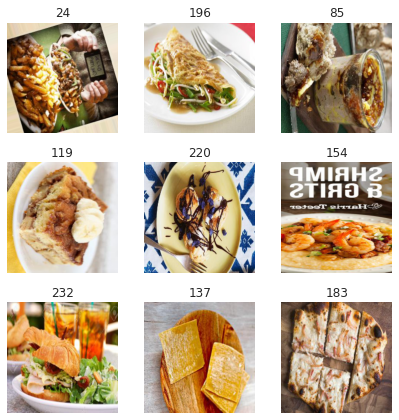

In [0]:
data.show_batch(rows=3, figsize=(6,6))

In [0]:
gc.collect() #Garbage Collector 

0

In [0]:
def top_3(preds, targs):
    #Defining the top 3
    return top_k_accuracy(preds, targs, 3)

### Stage1

In [0]:
#create a CNN based in resent
learner = cnn_learner(data, models.resnet152, metrics=accuracy)

In [0]:
#learner = learner.load('/content/drive/My Drive/resnet152/experimental_stage-1-Resnet152')

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.63E-03
Min loss divided by 10: 3.31E-03


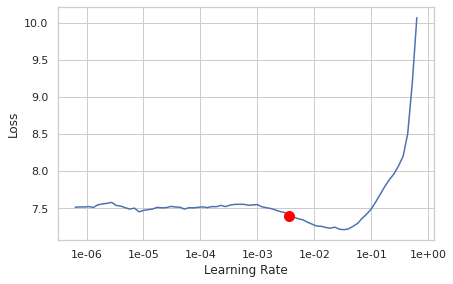

In [0]:
#choose a good one learning rate
learner.lr_find()
learner.recorder.plot(suggestion=True)

In [0]:
learner.fit_one_cycle(5,3.63e-03)
#learner.fit_one_cycle(5,2.09e-03)

epoch,train_loss,valid_loss,accuracy,time
0,3.506458,2.902024,0.321744,20:24
1,3.016614,2.372386,0.426380,20:21
2,2.836871,2.015186,0.514841,20:23
3,2.442711,1.701286,0.579957,20:18
4,2.299972,1.621803,0.589962,20:19


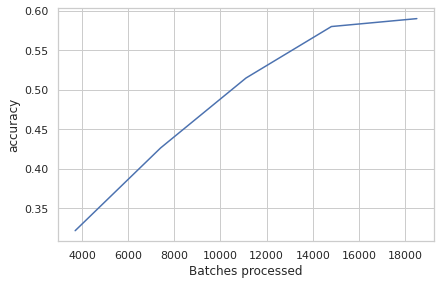

In [0]:
#plotting the metrics
learner.recorder.plot_metrics()

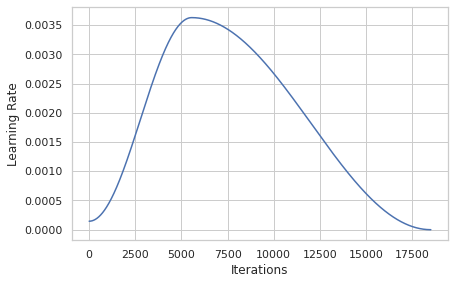

In [0]:
learner.recorder.plot_lr()

In [0]:
#Uncomment to save learner
learner.save('/content/drive/My Drive/resnet152/experimental_stage-1-Resnet152')

### **Making new state for the learner.**

In [0]:
#We change to acc to make it faster
learner = cnn_learner(data, models.resnet152, metrics=accuracy, ps = [0.4, 0.4, 0.4])
learner = learner.load('/content/drive/My Drive/resnet152/experimental_stage-1-Resnet152')

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 9.12E-07
Min loss divided by 10: 1.45E-06


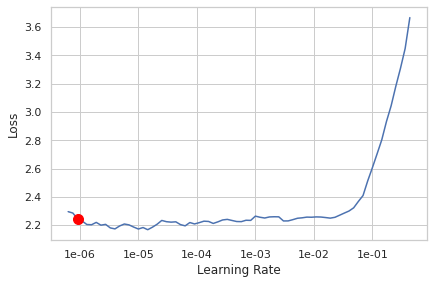

In [0]:
learner.lr_find()
learner.recorder.plot(suggestion=True)

In [0]:
learner.unfreeze()
learner.fit_one_cycle(10, slice(1e-06, 1e-04))

epoch,train_loss,valid_loss,accuracy,time
0,2.079781,1.573635,0.606970,26:22
1,2.124707,1.545496,0.610138,26:22
2,2.076356,1.509846,0.618643,26:47
3,2.072321,1.445354,0.634484,26:23
4,1.962342,1.406746,0.638819,26:25
5,1.864929,1.373862,0.645156,26:45
6,1.775691,1.349274,0.656828,26:21
7,1.729490,1.321977,0.658496,26:24
8,1.705321,1.316674,0.659330,26:22
9,1.724643,1.311296,0.660997,26:24


In [0]:
learner.save('/content/drive/My Drive/resnet152/experimental_stage-2-Resnet152')

### 3

In [0]:
learner = cnn_learner(data, models.resnet152, metrics=accuracy, ps = [0.6, 0.7, 0.6])
learner = learner.load('/content/drive/My Drive/resnet152/experimental_stage-2-Resnet152')

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/checkpoints/resnet152-b121ed2d.pth


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.91E-06
Min loss divided by 10: 5.75E-07


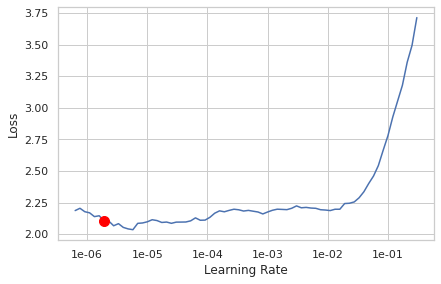

In [0]:
learner.lr_find()
learner.recorder.plot(suggestion=True)

In [0]:
learner.unfreeze()
learner.fit_one_cycle(10, slice(1e-06, 1e-04))

epoch,train_loss,valid_loss,accuracy,time
0,2.173846,1.327585,0.658246,26:57
1,2.203326,1.359628,0.653577,26:37
2,2.192842,1.394470,0.646490,26:22
3,2.169222,1.375825,0.650909,26:26
4,2.117514,1.362008,0.657996,26:21
5,2.012428,1.336625,0.664582,26:22
6,1.997277,1.319226,0.666667,26:22
7,1.900287,1.297936,0.671586,26:20
8,1.879734,1.290596,0.672670,26:28
9,1.876647,1.292325,0.673087,26:40


In [0]:
learner.save('/content/drive/My Drive/resnet152/experimental_stage-3-Resnet152')

### stage4

In [0]:
learner = cnn_learner(data, models.resnet152, metrics=accuracy)
learner = learner.load('/content/drive/My Drive/resnet152/experimental_stage-3-Resnet152')

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.32E-06
Min loss divided by 10: 1.91E-07


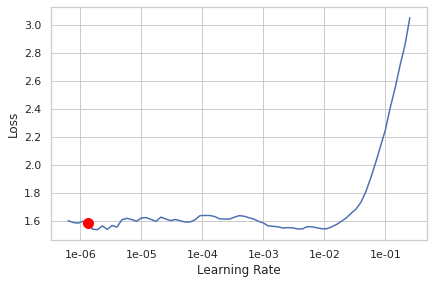

In [0]:
learner.lr_find()
learner.recorder.plot(suggestion=True)

In [0]:
learner.unfreeze()
learner.fit_one_cycle(15, slice(1e-06, 1e-05))

epoch,train_loss,valid_loss,accuracy,time
0,1.619513,1.282024,0.673670,26:22
1,1.516283,1.283325,0.674337,26:21
2,1.578351,1.284690,0.674504,26:29
3,1.557147,1.273733,0.676171,26:28


Buffered data was truncated after reaching the output size limit.

In [0]:
learner.validate()

[1.2462509, tensor(0.6814)]

In [0]:
learner.save('/content/drive/My Drive/resnet152/experimental_stage-4-Resnet152')

### **Testing and table.**


In [0]:
#learner = cnn_learner(data, models.resnet18,  metrics=[top_3])
#learner = learner.load('/content/drive/My Drive/resnet152/experimental_stage-2-Resnet152')

In [0]:
test = ImageList.from_folder('test_set/')
data.add_test(test)
preds, _ = learner.get_preds(ds_type=DatasetType.Test)
folder_names = [f.name for f in learner.data.test_ds.items]

In [0]:
preds.argmax(axis= 1)

tensor([111, 191, 199,  ..., 171,  71,  50])

In [0]:
order_df = read_csv('ifood2019_sample_submission.csv')
prediction_df = load_prediction_to_top_3(preds,folder_names,order_df)
prediction_df.head(10)

,img_name,label
0,test_000000.jpg,179 224 143
1,test_000001.jpg,16 32 126
2,test_000002.jpg,88 153 67
3,test_000003.jpg,51 201 232
4,test_000004.jpg,56 157 106
5,test_000005.jpg,125 238 105
6,test_000006.jpg,120 144 44
7,test_000007.jpg,240 206 215
8,test_000008.jpg,139 209 107
9,test_000009.jpg,119 227 48


In [0]:
prediction_df.to_csv('ResNet152-40.csv', index=False)